In [1]:
#start new

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from sklearn.utils import shuffle
import csv
import math
import matplotlib.pyplot as plt 
import array
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm_notebook
from keras.utils import np_utils
%matplotlib inline

Using TensorFlow backend.


In [3]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10 ## number of clusters
PHI = [] ## to store design matrix
IsSynthetic = False
Width = 0

In [4]:
#Processing data and categorisizing it into Concatenated HumanObserved,Subtracted HumanObserved,Concatenated GSC,Subtracted GSC
#Mixing Same and different pairs in almost same proportion in both HumanObserved and GSC
def ProcessData(filePath,samePairs_Path,diffPairs_Path,DataType):
    
    with open(filePath, "r") as f:
        mainFile = pd.read_csv(f)
        
    if(DataType == 'HOD'):
      maxLimit=9
       
      with open(samePairs_Path, "r") as f:
        samePair = pd.read_csv(f)

      with open(diffPairs_Path, "r") as f:
        diffnPair = pd.read_csv(f)
        
    elif(DataType == 'GSC'):
      maxLimit=512
        
      with open(samePairs_Path, "r") as f:
        samePair = pd.read_csv(f)
        samePair = samePair.iloc[:1000] #taking 1000 samples from samePair excel for GSC
      with open(diffPairs_Path, "r") as f:
        diffnPair = pd.read_csv(f)
        diffnPair = diffnPair.iloc[:1000] #taking 1000 samples from differentPair excel for GSC
       

    newFile = [] # creating a new dataframe to store the combined data
    

    diffnPair = diffnPair.take(np.random.permutation(len(diffnPair))[:samePair.shape[0]])
    #print(diffnPair.shape)

    frames = [samePair, diffnPair]
    newFile = pd.concat(frames)
    
    #Shuffling the data
    newFile = shuffle(newFile)
    
    if(DataType == 'HOD'):
       maxLimit=9
    elif(DataType == 'GSC'):
       maxLimit=512
        
    columnList1 = []
    for i in range(1,maxLimit+1):
     columnList1.append('%dA' % i)
    for i in range(1,maxLimit+1):
     columnList1.append('%dB' % i)

    newFile = newFile.reindex(columns=[*newFile.columns.tolist(), *columnList1], fill_value=0)
    
    #extracting features for the corresponding ImgA_Id and ImgB_id from Human observed file/GSC file 
    count =-1
    index = 0
    for id2 in newFile["img_id_A"]:
      count=count+1
      i=-1
      for id1 in mainFile["img_id"]:
        i=i+1
        if id2 == id1:
            for k in range(3,maxLimit+3):
                newFile.iloc[count, k] = mainFile.iloc[i, k-1]
                index = k
                
                

    count=-1
   
    for id2 in newFile["img_id_B"]:
      count=count+1
      i=-1
      for id1 in mainFile["img_id"]:
        i=i+1
        if id2 == id1:
            for k in range(index+1,maxLimit+index+1):
              newFile.iloc[count, k] = mainFile.iloc[i, k-maxLimit-1]
            #newFile.iloc[count, 12] = mainFile.iloc[i, 2]           
    
    return newFile

#only returns the required 18 feature columns 
def ProcessConcatenated(RawData,DataType):

   if(DataType == 'HOD'):
      maxLimit=9
   elif(DataType == 'GSC'):
      maxLimit=512
   
   columnList1 = []
   for i in range(1,maxLimit+1):
     columnList1.append('%dA' % i)
   for i in range(1,maxLimit+1):
     columnList1.append('%dB' % i)
 
   return RawData[[*columnList1]]

#only returns the required 9 columns after feature subtraction
def FeatureSubtraction(ProcessedData_Concatenated,DataType):
   subtractedFeatures = ProcessedData_Concatenated
   if(DataType == 'HOD'):
      maxLimit=9
   elif(DataType == 'GSC'):
       maxLimit=512
        
   subtractedFeatures = ProcessedData_Concatenated

   columnList = []
   for i in range(1,maxLimit+1):
    columnList.append('A-B-%d' % i)
    
   subtractedFeatures = subtractedFeatures .reindex(columns=[*subtractedFeatures.columns.tolist(), *columnList], fill_value=0)


   for i in range(0,subtractedFeatures.shape[0],1):
     for j in range(0,maxLimit,1):
       subtractedFeatures.iloc[i,j+2*maxLimit] = (subtractedFeatures.iloc[i,j])-(subtractedFeatures.iloc[i,j+maxLimit])
      
   subtractedFeatures = subtractedFeatures[[*columnList]]
   return subtractedFeatures

In [5]:
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    rawDataT=rawData.transpose()
    T_len = int(math.ceil(len(rawDataT)*0.01*TrainingPercent))
    d2 = rawData.iloc[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    rawDataT=rawData.transpose()
    valSize = int(math.ceil(len(rawDataT)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData.iloc[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

In [6]:
#GSC
RawData_GSC   = ProcessData('GSC-Features.csv','same_pairs_GSC.csv','diffn_pairs_GSC.csv','GSC')
RawTarget_GSC = RawData_GSC['target']

ProcessedData_Concatenated_GSC = ProcessConcatenated(RawData_GSC,'GSC')
Data_Concatenated_GSC = ProcessedData_Concatenated_GSC.transpose()

ProcessedData_Subtraction_GSC = FeatureSubtraction(ProcessedData_Concatenated_GSC,'GSC')
Data_Subtraction_GSC = ProcessedData_Subtraction_GSC.transpose()

#Human Observed Data RAW DATA
RawData_HOD   = ProcessData('HumanObserved-Features-Data.csv','same_pairs.csv','diffn_pairs.csv','HOD')#complete dataset with ImageA_Id, ImageB_Id,target,FA1-FA9,FB1-FB9
RawTarget_HOD = RawData_HOD['target']

ProcessedData_Concatenated_HOD = ProcessConcatenated(RawData_HOD,'HOD')# only feature columns from 1-18
Data_Concatenated_HOD = ProcessedData_Concatenated_HOD.transpose()

ProcessedData_Subtraction_HOD = FeatureSubtraction(ProcessedData_Concatenated_HOD,'HOD')# only feature columns from 1-9
Data_Subtraction_HOD = ProcessedData_Subtraction_HOD.transpose()

In [7]:
#Human Observed Data Training Data
TrainingTarget_HOD = np.array(GenerateTrainingTarget(RawTarget_HOD,TrainingPercent))
TrainingData_Concatenated_HOD   = GenerateTrainingDataMatrix(Data_Concatenated_HOD,TrainingPercent)
TrainingData_Subtraction_HOD   = GenerateTrainingDataMatrix(Data_Subtraction_HOD,TrainingPercent)

#GSC
TrainingTarget_GSC = np.array(GenerateTrainingTarget(RawTarget_GSC,TrainingPercent))
TrainingData_Concatenated_GSC   = GenerateTrainingDataMatrix(Data_Concatenated_GSC,TrainingPercent)
TrainingData_Subtraction_GSC   = GenerateTrainingDataMatrix(Data_Subtraction_GSC,TrainingPercent)

In [8]:
#Human Observed Data Validation Data
ValDataTarget_HOD = np.array(GenerateValTargetVector(RawTarget_HOD,ValidationPercent, (len(TrainingTarget_HOD))))
ValData_Concatenated_HOD = GenerateValData(Data_Concatenated_HOD,ValidationPercent, (len(TrainingTarget_HOD)))
ValData_Subtraction_HOD = GenerateValData(Data_Subtraction_HOD,ValidationPercent, (len(TrainingTarget_HOD)))

#GSC
ValDataTarget_GSC = np.array(GenerateValTargetVector(RawTarget_GSC,ValidationPercent, (len(TrainingTarget_GSC))))
ValData_Concatenated_GSC    = GenerateValData(Data_Concatenated_GSC,ValidationPercent, (len(TrainingTarget_GSC)))
ValData_Subtraction_GSC    = GenerateValData(Data_Subtraction_GSC,ValidationPercent, (len(TrainingTarget_GSC)))

In [9]:
#Human Observed Data Test Data
TestDataTarget_HOD = np.array(GenerateValTargetVector(RawTarget_HOD,TestPercent, (len(TrainingTarget_HOD)+len(ValDataTarget_HOD))))
TestData_Subtraction_HOD = GenerateValData(Data_Subtraction_HOD,TestPercent, (len(TrainingTarget_HOD)+len(ValDataTarget_HOD)))
TestData_Concatenated_HOD = GenerateValData(Data_Concatenated_HOD,TestPercent, (len(TrainingTarget_HOD)+len(ValDataTarget_HOD)))


#GSC
TestDataTarget_GSC = np.array(GenerateValTargetVector(RawTarget_GSC,TestPercent, (len(TrainingTarget_GSC)+len(ValDataTarget_GSC))))
TestData_Concatenated_GSC = GenerateValData(Data_Concatenated_GSC,TestPercent, (len(TrainingTarget_GSC)+len(ValDataTarget_GSC)))
TestData_Subtraction_GSC = GenerateValData(Data_Subtraction_GSC,TestPercent, (len(TrainingTarget_GSC)+len(ValDataTarget_GSC)))



Closed Form Solution


In [10]:
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic): #create the covariance matrix
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    
    for i in range(0,len(Data)):
        vct = []
        for j in range(0,TrainingLen):
            vct.append(Data.iloc[i,j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma


def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):   
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x


def GetWeightsClosedForm(PHI, T, Lambda):#The closed-form solution with least-squared regularization for calculating weights
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):#Calcuating the design matrix
    
    DataT = np.transpose(Data)
    
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))   
    
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    
    BigSigInv = np.linalg.pinv(BigSigma)
   
    for  C in range(0,len(MuMatrix)):
        for R in range(0,TrainingLen):
            PHI[R][C] = GetRadialBasisOut(DataT.iloc[R], MuMatrix[C], BigSigInv)

    return PHI

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataTarget):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataTarget[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataTarget[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

def Get_PhiMatrix_GradientDescent(RawData,Data,Percent):#Find Phi Matrix for Gradient Descent optimization solution
     ErmsArr = []
     AccuracyArr = []

     kmeans = KMeans(n_clusters=10, random_state=0).fit(np.transpose(Data))
     Mu = kmeans.cluster_centers_
     BigSigma     = GenerateBigSigma(RawData, Mu, Percent,IsSynthetic)

     PHI = GetPhiMatrix(RawData, Mu, BigSigma, Percent)
     
     return PHI

In [11]:
#Finding ERMS and Accuracy through Closed Form Solution
def ClosedFormSolution(RawData,TrainingData,TestingData,ValidationData,TrainingTarget,TestingTarget,ValidationTarget):
    
    clusters = []
    ErmsArr = []
    AccuracyArr = []
    clusters_erms=[]
    for m in range(1,40,10):#changing number of clusters

         ErmsArr = []
         AccuracyArr = []

         kmeans = KMeans(n_clusters=m, random_state=0).fit(np.transpose(TrainingData)) #clustering using K-means
         Mu = kmeans.cluster_centers_
         BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)

         TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)

         W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
         TEST_PHI     = GetPhiMatrix(TestingData, Mu, BigSigma, 100) 
         VAL_PHI      = GetPhiMatrix(ValidationData, Mu, BigSigma, 100)

         TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
         VAL_TEST_OUT = GetValTest(VAL_PHI,W)
         TEST_OUT     = GetValTest(TEST_PHI,W)

         TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))

         ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValidationTarget))

         TestAccuracy       = str(GetErms(TEST_OUT,TestingTarget))
     
    
         print ("M ="+str(int(m)))
         print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
         print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
         print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))
         print ("Accuracy Testing   = " + str(float(TestAccuracy.split(',')[0])))  
         
         ErmsArr.append(float(TestAccuracy.split(',')[1]))
         AccuracyArr.append(float(TestAccuracy.split(',')[0]))
    
         average_of_cluster=sum(ErmsArr) / float(len(ErmsArr))
         clusters_erms.append(average_of_cluster)
         clusters.append(m) 
         ErmsArr.clear()

    plt.plot(clusters, clusters_erms)
    # x axis values 
    plt.xlabel('Clusters') 
    # naming the y axis 
    plt.ylabel('ErmsArr') 
    plt.title('Number of Clusters Vs ERMS') 
    plt.show()


Human Observed Dataset Concatenated
M =1
E_rms Training   = 0.49927417736160234
E_rms Validation = 0.49886789198993564
E_rms Testing    = 0.4997553463109964
Accuracy Testing   = 52.22929936305732
M =11
E_rms Training   = 0.4974483050380479
E_rms Validation = 0.49717453410580814
E_rms Testing    = 0.49740766960244837
Accuracy Testing   = 54.140127388535035
M =21
E_rms Training   = 0.49588396431709214
E_rms Validation = 0.4933211867791888
E_rms Testing    = 0.4969876521282622
Accuracy Testing   = 52.22929936305732
M =31
E_rms Training   = 0.49570754843409404
E_rms Validation = 0.4931987913399498
E_rms Testing    = 0.4965114355936149
Accuracy Testing   = 52.22929936305732


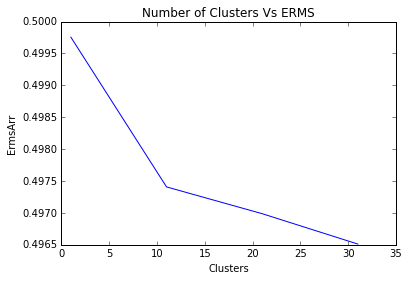

Human Observed Dataset Subtracted
M =1
E_rms Training   = 0.4995602168623239
E_rms Validation = 0.4995449872861013
E_rms Testing    = 0.5002137502886809
Accuracy Testing   = 50.318471337579616
M =11
E_rms Training   = 0.49806096302047576
E_rms Validation = 0.49893671197183753
E_rms Testing    = 0.49786396795587534
Accuracy Testing   = 52.86624203821656
M =21
E_rms Training   = 0.4973610373166957
E_rms Validation = 0.49776730050111234
E_rms Testing    = 0.49775499812978663
Accuracy Testing   = 53.503184713375795
M =31
E_rms Training   = 0.4969945795083855
E_rms Validation = 0.4965454266331123
E_rms Testing    = 0.49746435123210075
Accuracy Testing   = 55.4140127388535


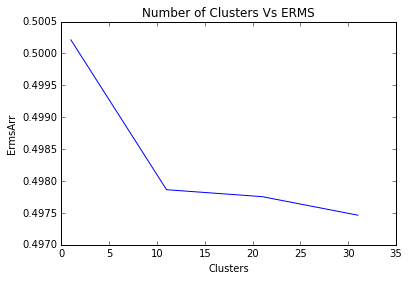

GSC Concatenated
M =1
E_rms Training   = 0.6577916203000105
E_rms Validation = 0.6495541528222779
E_rms Testing    = 0.6628695451232058
Accuracy Testing   = 48.743718592964825
M =11
E_rms Training   = 0.3184527709580927
E_rms Validation = 0.31868949602650193
E_rms Testing    = 0.33625205613222786
Accuracy Testing   = 86.4321608040201
M =21
E_rms Training   = 0.2981528101954845
E_rms Validation = 0.2976429661315214
E_rms Testing    = 0.31504306722802644
Accuracy Testing   = 88.94472361809045
M =31
E_rms Training   = 0.2818303057129859
E_rms Validation = 0.28138022340859725
E_rms Testing    = 0.31604800681778805
Accuracy Testing   = 88.44221105527639


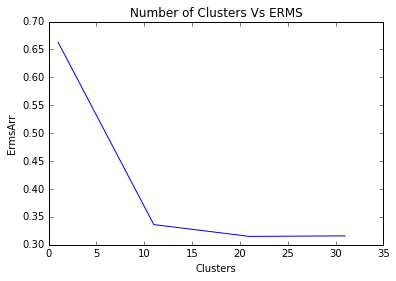

GSC Subtracted
M =1
E_rms Training   = 0.5468869245402255
E_rms Validation = 0.5439947214461346
E_rms Testing    = 0.5474737362640206
Accuracy Testing   = 35.678391959798994
M =11
E_rms Training   = 0.23530702466085035
E_rms Validation = 0.2403242361150988
E_rms Testing    = 0.2472459298854931
Accuracy Testing   = 94.47236180904522
M =21
E_rms Training   = 0.22356009197479784
E_rms Validation = 0.22971558982395102
E_rms Testing    = 0.2512626875355442
Accuracy Testing   = 93.46733668341709
M =31
E_rms Training   = 0.21095594667312478
E_rms Validation = 0.2168716859923426
E_rms Testing    = 0.23946495591390904
Accuracy Testing   = 95.47738693467336


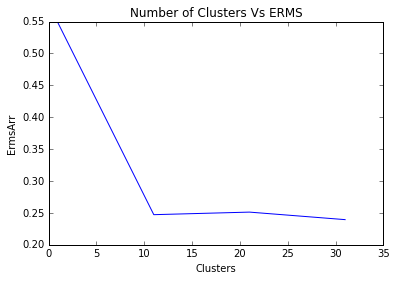

In [12]:
#ERMS and Accuracy through Closed Form Solution for all 4 datasets
print('Human Observed Dataset Concatenated')
ClosedFormSolution(Data_Concatenated_HOD,TrainingData_Concatenated_HOD,TestData_Concatenated_HOD,ValData_Concatenated_HOD,TrainingTarget_HOD,TestDataTarget_HOD,ValDataTarget_HOD)
print('Human Observed Dataset Subtracted')
ClosedFormSolution(Data_Subtraction_HOD,TrainingData_Subtraction_HOD,TestData_Subtraction_HOD,ValData_Subtraction_HOD,TrainingTarget_HOD,TestDataTarget_HOD,ValDataTarget_HOD)
print('GSC Concatenated')
ClosedFormSolution(Data_Concatenated_GSC,TrainingData_Concatenated_GSC,TestData_Concatenated_GSC,ValData_Concatenated_GSC,TrainingTarget_GSC,TestDataTarget_GSC,ValDataTarget_GSC)
print('GSC Subtracted')
ClosedFormSolution(Data_Subtraction_GSC,TrainingData_Subtraction_GSC,TestData_Subtraction_GSC,ValData_Subtraction_GSC,TrainingTarget_GSC,TestDataTarget_GSC,ValDataTarget_GSC)

Gradient Descent

In [13]:
#ERMS through Gradient Descent Optimization
def GardientDescent(RawData,TrainingData,TestData,ValData,TrainingTarget,TestDataTarget,ValDataTarget):
    
    TRAINING_PHI = Get_PhiMatrix_GradientDescent(RawData,TrainingData,80)
    W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
    TEST_PHI = Get_PhiMatrix_GradientDescent(TestData,TrainingData,100)
    VAL_PHI = Get_PhiMatrix_GradientDescent(ValData,TrainingData,100)
    
    W_Now        = np.dot(220, W)
    La           = 2
    learningRate = 0.01
    L_Erms_Val   = []
    L_Erms_TR    = []
    L_Erms_Test  = []
    W_Mat        = []
    Clusters     = []
    Dataset      = []
    Erms_array   = []
    learningRate_array = []
    Lambda_array = []
    
    for n in range(1,6):
     for i in range(0,n*100):# selecting datapoints 100,200,300,400,500

        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((TrainingTarget_HOD[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
        La = n
        La_Delta_E_W  = np.dot(La,W_Now)
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
        Delta_W       = -np.dot(learningRate,Delta_E)
        W_T_Next      = W_Now + Delta_W
        W_Now         = W_T_Next

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget_HOD)
        L_Erms_TR.append(float(Erms_TR.split(',')[1]))

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataTarget_HOD)
        L_Erms_Val.append(float(Erms_Val.split(',')[1]))

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
        Erms_Test = GetErms(TEST_OUT,TestDataTarget_HOD)
        L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    
     print ('----------Gradient Descent Solution--------------------')
     print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
     print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
     print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
    
     Erms_array.append(np.around(min(L_Erms_Test),5))  
     Dataset.append(n*100)
     #learningRate_array.append(learningRate)
     Lambda_array.append(La)
    
    plt.plot(Dataset, Erms_array)
    # x axis values 
    plt.xlabel('Data points') 
    # naming the y axis 
    plt.ylabel('ErmsArr') 

    plt.title('Data Points Vs ERMS') 
    plt.show()

    ##2nd
    plt.plot(Lambda_array, Erms_array)
    # x axis values 
    plt.xlabel('Lambda') 
    # naming the y axis 
    plt.ylabel('ErmsArr') 

    plt.title('Lambda Vs ERMS') 
    plt.show()

Human Observed Dataset Concatenated
----------Gradient Descent Solution--------------------
E_rms Training   = 2.60362
E_rms Validation = 2.74615
E_rms Testing    = 2.81509
----------Gradient Descent Solution--------------------
E_rms Training   = 0.49761
E_rms Validation = 0.49792
E_rms Testing    = 0.49666
----------Gradient Descent Solution--------------------
E_rms Training   = 0.49761
E_rms Validation = 0.49754
E_rms Testing    = 0.49618
----------Gradient Descent Solution--------------------
E_rms Training   = 0.49761
E_rms Validation = 0.49754
E_rms Testing    = 0.49618
----------Gradient Descent Solution--------------------
E_rms Training   = 0.49761
E_rms Validation = 0.49754
E_rms Testing    = 0.49618


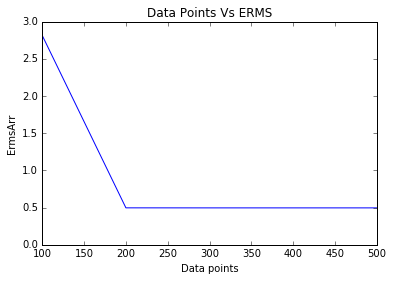

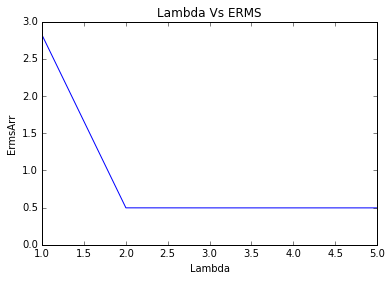

---------------------------------------------------------
Human Observed Dataset Subtracted
----------Gradient Descent Solution--------------------
E_rms Training   = 2.55735
E_rms Validation = 2.50738
E_rms Testing    = 2.7304
----------Gradient Descent Solution--------------------
E_rms Training   = 0.49813
E_rms Validation = 0.49868
E_rms Testing    = 0.49597
----------Gradient Descent Solution--------------------
E_rms Training   = 0.49813
E_rms Validation = 0.4984
E_rms Testing    = 0.49595
----------Gradient Descent Solution--------------------
E_rms Training   = 0.49813
E_rms Validation = 0.4984
E_rms Testing    = 0.49595
----------Gradient Descent Solution--------------------
E_rms Training   = 0.49813
E_rms Validation = 0.4984
E_rms Testing    = 0.49595


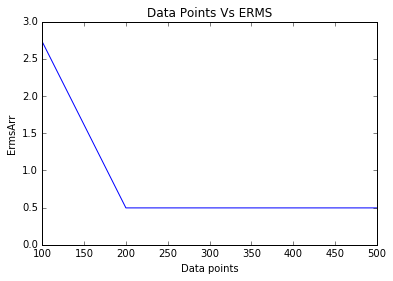

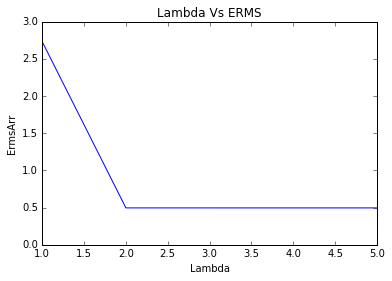

---------------------------------------------------------
GSC Concatenated


IndexError: index 1266 is out of bounds for axis 0 with size 1266

In [14]:
#ERMS through Gradient Descent for all 4 datasets
print('Human Observed Dataset Concatenated')
GardientDescent(Data_Concatenated_HOD,TrainingData_Concatenated_HOD,TestData_Concatenated_HOD,ValData_Concatenated_HOD,TrainingTarget_HOD,TestDataTarget_HOD,ValDataTarget_HOD)
print('---------------------------------------------------------')
print('Human Observed Dataset Subtracted')
GardientDescent(Data_Subtraction_HOD,TrainingData_Subtraction_HOD,TestData_Subtraction_HOD,ValData_Subtraction_HOD,TrainingTarget_HOD,TestDataTarget_HOD,ValDataTarget_HOD)
print('---------------------------------------------------------')
print('GSC Concatenated')
GardientDescent(Data_Concatenated_GSC,TrainingData_Concatenated_GSC,TestData_Concatenated_GSC,ValData_Concatenated_GSC,TrainingTarget_GSC,TestDataTarget_GSC,ValDataTarget_GSC)
print('---------------------------------------------------------')
print('GSC Subtracted')
GardientDescent(Data_Subtraction_GSC,TrainingData_Subtraction_GSC,TestData_Subtraction_GSC,ValData_Subtraction_GSC,TrainingTarget_GSC,TestDataTarget_GSC,ValDataTarget_GSC)

In [15]:
#Logistic regression

In [16]:
#Finding Accuracy through logistic regression
#Implementing logistic regression as one layer neural network 
def LogisticRegression(RawData,TrainingData,TestData,ValData,TrainingTarget,TestDataTarget,ValDataTarget,Datatype,Dataset):
    
    LEARNING_RATE = 0.5
    
    # Initializing the weights to Normal Distribution
    def init_weights(shape):
        return tf.Variable(tf.random_normal(shape,stddev=0.01))
    
    # Defining Placeholder
    if (Dataset == 'HOD'):
        if (Datatype == 'Concatenated'):
          inputTensor  = tf.placeholder(tf.float32, [None, 18])#18
          weightSize = 18
        elif (Datatype == 'Subtract'):
          inputTensor  = tf.placeholder(tf.float32, [None, 9])#9
          weightSize = 9
    elif (Dataset == 'GSC'):
        if (Datatype == 'Concatenated'):
          inputTensor  = tf.placeholder(tf.float32, [None, 1024])
          weightSize = 1024
        elif (Datatype == 'Subtract'):
          inputTensor  = tf.placeholder(tf.float32, [None, 512])
          weightSize = 512
        
    outputTensor = tf.placeholder(tf.float32, [None, 2])#2
   
    # Initializing the weights
    weights = init_weights([weightSize, 2])


    # Computing values at the output layer
    output_layer =  tf.nn.sigmoid(tf.matmul(inputTensor, weights))

    # Defining Error Function
    error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

    # Defining Learning Algorithm and Training Parameters
    training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)

    # Prediction Function
    prediction = tf.argmax(output_layer, 1)
    
    #Train the Model

    NUM_OF_EPOCHS = 1000
    BATCH_SIZE = 50

    training_accuracy = []

    ProcessedTestingTarget = np_utils.to_categorical(np.array(TestDataTarget),2)
    ProcessedTrainingTarget = np_utils.to_categorical(np.array(TrainingTarget),2)
    ProcessedTrainingData = TrainingData.transpose()

    with tf.Session() as sess:

        # Set Global Variables ? It helps initialize all Variables that have been previously declared
        tf.global_variables_initializer().run()

        #encodeLabel(TrainingTarget_HOD)     
        for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):


            # Start batch training
            for start in range(0, len(ProcessedTrainingData), BATCH_SIZE):
                end = start + BATCH_SIZE
                sess.run(training, feed_dict={inputTensor: ProcessedTrainingData[start:end], 
                                              outputTensor: ProcessedTrainingTarget[start:end]})


            # Training accuracy for an epoch
            training_accuracy.append(np.mean(np.argmax(ProcessedTrainingTarget, axis=1) ==
                                 sess.run(prediction, feed_dict={inputTensor: ProcessedTrainingData,
                                                                 outputTensor: ProcessedTrainingTarget})))

        # Testing
        predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: TestData.transpose()})
    
    #plotting the graphs
    df = pd.DataFrame()
    df['acc'] = training_accuracy
    ##df.plot(grid=True)
    df.plot(subplots=True, grid=True, figsize=(10,15))

    #Testing The Model
    wrong   = 0
    right   = 0

    predictedTestLabelList = []
    ""
    for i,j in zip(ProcessedTestingTarget,predictedTestLabel):
        predictedTestLabelList.append(j)

        if np.argmax(i) == j:
            right = right + 1
        else:
            wrong = wrong + 1

    print("Errors: " + str(wrong), " Correct :" + str(right))

    print("Testing Accuracy: " + str(right/(right+wrong)*100))

Human Observed Dataset Concatenated



Errors: 68  Correct :89
Testing Accuracy: 56.68789808917197
---------------------------------------------------------
Human Observed Dataset Subtracted



Errors: 75  Correct :82
Testing Accuracy: 52.22929936305732
---------------------------------------------------------
GSC Concatenated



Errors: 5  Correct :194
Testing Accuracy: 97.48743718592965
---------------------------------------------------------
GSC Subtracted



Errors: 15  Correct :184
Testing Accuracy: 92.46231155778895


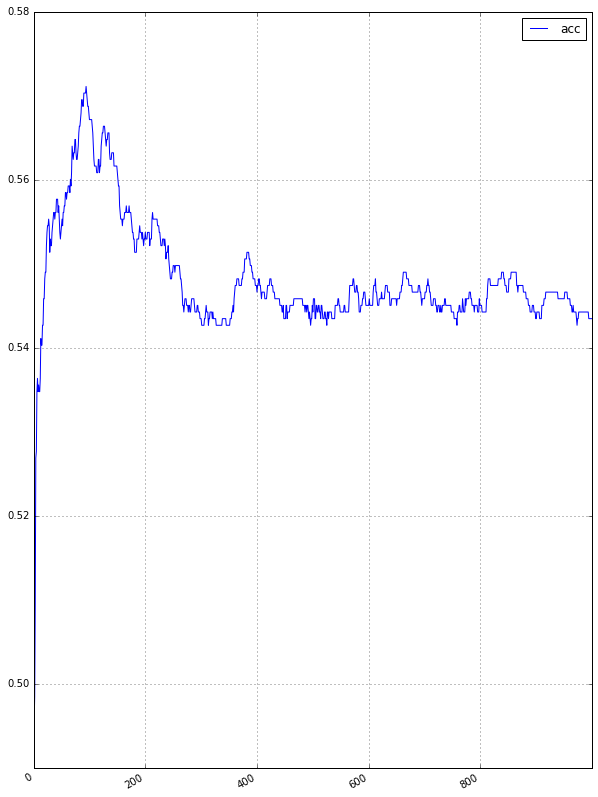

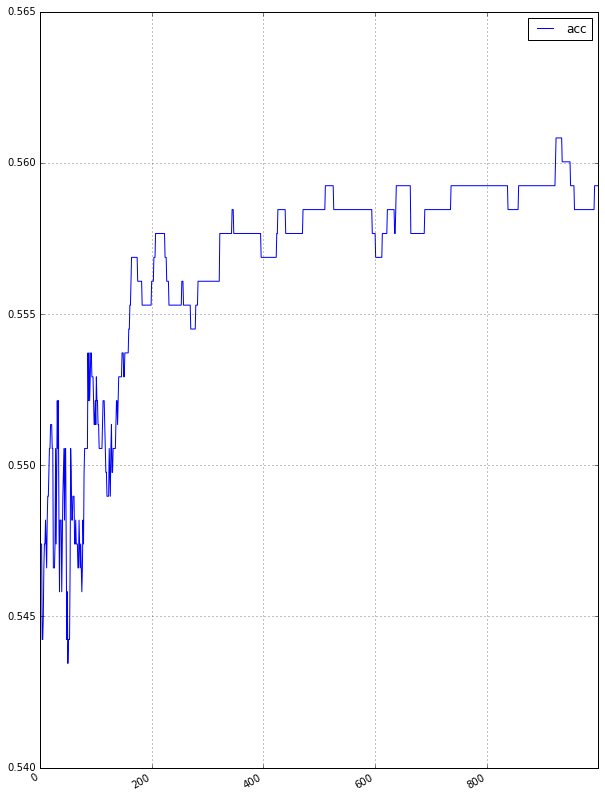

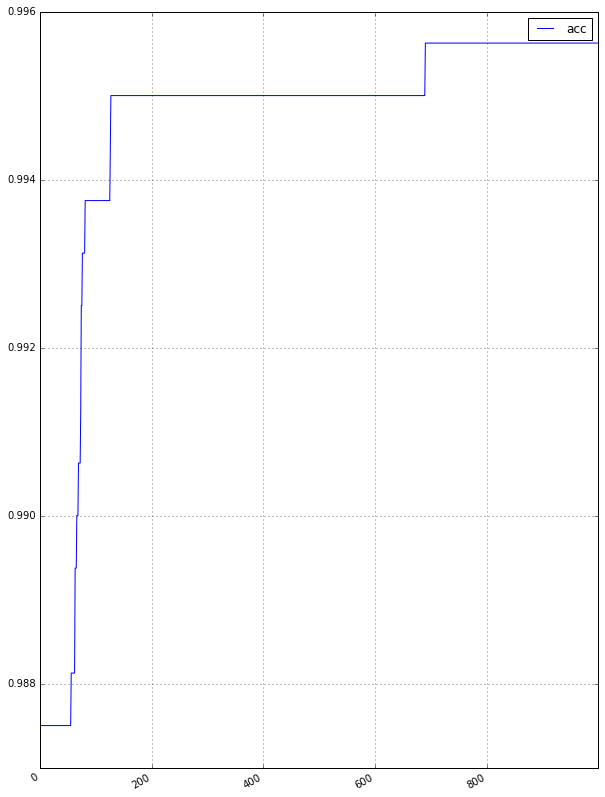

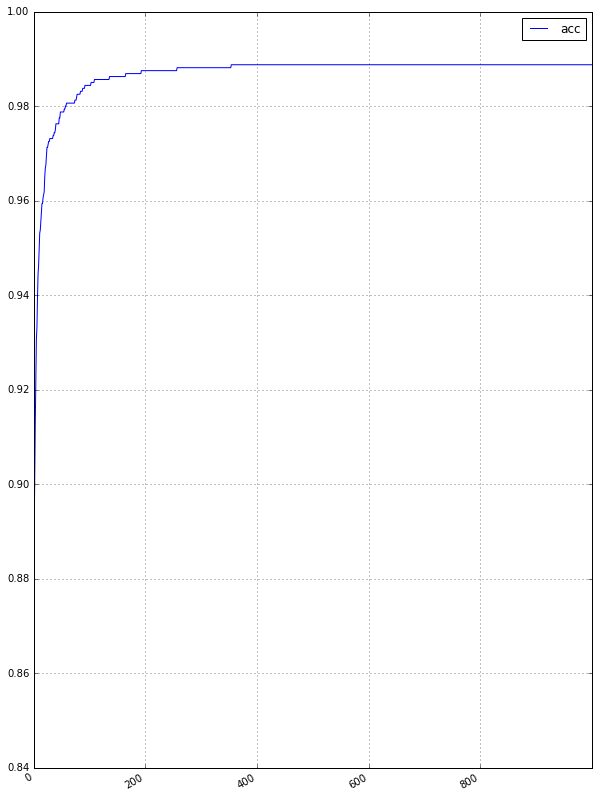

In [17]:
#Accuracy through Logistic Regression for all 4 datasets
print('Human Observed Dataset Concatenated')
LogisticRegression(Data_Concatenated_HOD,TrainingData_Concatenated_HOD,TestData_Concatenated_HOD,ValData_Concatenated_HOD,TrainingTarget_HOD,TestDataTarget_HOD,ValDataTarget_HOD,'Concatenated','HOD')
print('---------------------------------------------------------')
print('Human Observed Dataset Subtracted')
LogisticRegression(Data_Subtraction_HOD,TrainingData_Subtraction_HOD,TestData_Subtraction_HOD,ValData_Subtraction_HOD,TrainingTarget_HOD,TestDataTarget_HOD,ValDataTarget_HOD,'Subtract','HOD')
print('---------------------------------------------------------')
print('GSC Concatenated')
LogisticRegression(Data_Concatenated_GSC,TrainingData_Concatenated_GSC,TestData_Concatenated_GSC,ValData_Concatenated_GSC,TrainingTarget_GSC,TestDataTarget_GSC,ValDataTarget_GSC,'Concatenated','GSC')
print('---------------------------------------------------------')
print('GSC Subtracted')
LogisticRegression(Data_Subtraction_GSC,TrainingData_Subtraction_GSC,TestData_Subtraction_GSC,ValData_Subtraction_GSC,TrainingTarget_GSC,TestDataTarget_GSC,ValDataTarget_GSC,'Subtract','GSC')

Neural Network Implementation

In [18]:
#Finding Accuracy through Neural Network
#Implementing Neural Network 
def NeuralNetwork(RawData,TrainingData,TestData,ValData,TrainingTarget,TestDataTarget,ValDataTarget,Datatype,Dataset):
    
    LEARNING_RATE = 0.5
    
    # Initializing the weights to Normal Distribution
    def init_weights(shape):
        return tf.Variable(tf.random_normal(shape,stddev=0.01))
    
    # Defining Placeholder
    if (Dataset == 'HOD'):
        if (Datatype == 'Concatenated'):
          NUM_HIDDEN_NEURONS_LAYER_1 = 18
          inputTensor  = tf.placeholder(tf.float32, [None, 18])#18
          # Initializing the input to hidden layer weights
          input_hidden_weights  = init_weights([18, NUM_HIDDEN_NEURONS_LAYER_1])
          weightSize = 18
        elif (Datatype == 'Subtract'):
          NUM_HIDDEN_NEURONS_LAYER_1 = 9
          inputTensor  = tf.placeholder(tf.float32, [None, 9])#9
          # Initializing the input to hidden layer weights
          input_hidden_weights  = init_weights([9, NUM_HIDDEN_NEURONS_LAYER_1])
          weightSize = 9
          
    elif (Dataset == 'GSC'):
        if (Datatype == 'Concatenated'):
          NUM_HIDDEN_NEURONS_LAYER_1 = 1024
          inputTensor  = tf.placeholder(tf.float32, [None, 1024])
          # Initializing the input to hidden layer weights
          input_hidden_weights  = init_weights([1024, NUM_HIDDEN_NEURONS_LAYER_1])
          weightSize = 1024
        elif (Datatype == 'Subtract'):
          NUM_HIDDEN_NEURONS_LAYER_1 = 512
          inputTensor  = tf.placeholder(tf.float32, [None, 512])
          # Initializing the input to hidden layer weights
          input_hidden_weights  = init_weights([512, NUM_HIDDEN_NEURONS_LAYER_1])
          weightSize = 512
        
    outputTensor = tf.placeholder(tf.float32, [None, 2])#2
    
    # Initializing the hidden to output layer weights
    hidden_output_weights = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, 2])

    # Computing values at the hidden layer
    hidden_layer = tf.nn.sigmoid(tf.matmul(inputTensor, input_hidden_weights))

    # Computing values at the output layer
    output_layer = tf.matmul(hidden_layer, hidden_output_weights)

    # Defining Error Function
    error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

    # Defining Learning Algorithm and Training Parameters
    training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)

    # Prediction Function
    prediction = tf.argmax(output_layer, 1)
    
    #Train the Model
    NUM_OF_EPOCHS = 1000
    BATCH_SIZE = 50

    training_accuracy = []

    ProcessedTestingTarget = np_utils.to_categorical(np.array(TestDataTarget),2)
    ProcessedTrainingTarget = np_utils.to_categorical(np.array(TrainingTarget),2)
    ProcessedTrainingData = TrainingData.transpose()

    with tf.Session() as sess:

        # Set Global Variables ? It helps initialize all Variables that have been previously declared
        tf.global_variables_initializer().run()

        #encodeLabel(TrainingTarget_HOD)     
        for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):


            # Start batch training
            for start in range(0, len(ProcessedTrainingData), BATCH_SIZE):
                end = start + BATCH_SIZE
                sess.run(training, feed_dict={inputTensor: ProcessedTrainingData[start:end], 
                                              outputTensor: ProcessedTrainingTarget[start:end]})


            # Training accuracy for an epoch
            training_accuracy.append(np.mean(np.argmax(ProcessedTrainingTarget, axis=1) ==
                                 sess.run(prediction, feed_dict={inputTensor: ProcessedTrainingData,
                                                                 outputTensor: ProcessedTrainingTarget})))

        # Testing
        predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: TestData.transpose()})
    
    #plotting the graphs
    df = pd.DataFrame()
    df['acc'] = training_accuracy
    ##df.plot(grid=True)
    df.plot(subplots=True, grid=True, figsize=(10,15))

    #Testing The Model
    wrong   = 0
    right   = 0

    predictedTestLabelList = []
    ""
    for i,j in zip(ProcessedTestingTarget,predictedTestLabel):
        predictedTestLabelList.append(j)

        if np.argmax(i) == j:
            right = right + 1
        else:
            wrong = wrong + 1

    print("Errors: " + str(wrong), " Correct :" + str(right))

    print("Testing Accuracy: " + str(right/(right+wrong)*100))

Human Observed Dataset Concatenated



Errors: 73  Correct :84
Testing Accuracy: 53.503184713375795
---------------------------------------------------------
Human Observed Dataset Subtracted



Errors: 83  Correct :74
Testing Accuracy: 47.13375796178344
---------------------------------------------------------
GSC Concatenated



Errors: 3  Correct :196
Testing Accuracy: 98.49246231155779
---------------------------------------------------------
GSC Subtracted



Errors: 3  Correct :196
Testing Accuracy: 98.49246231155779


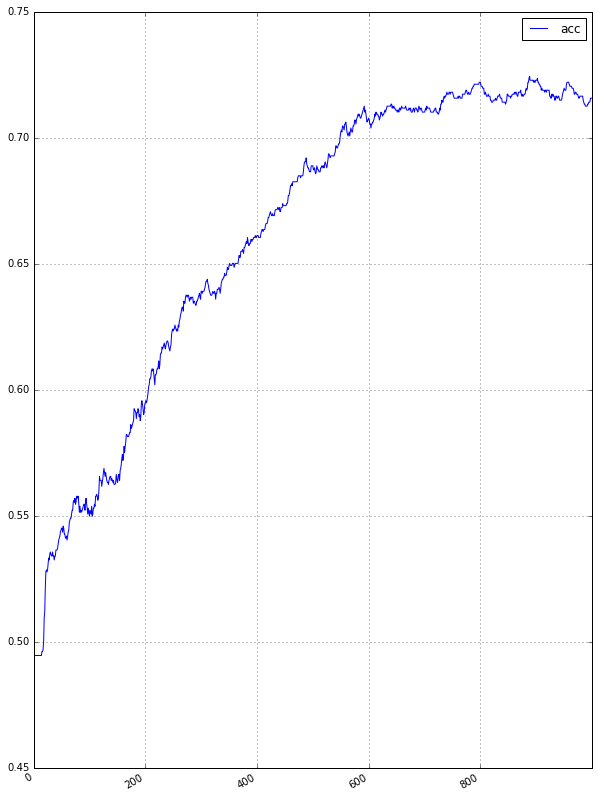

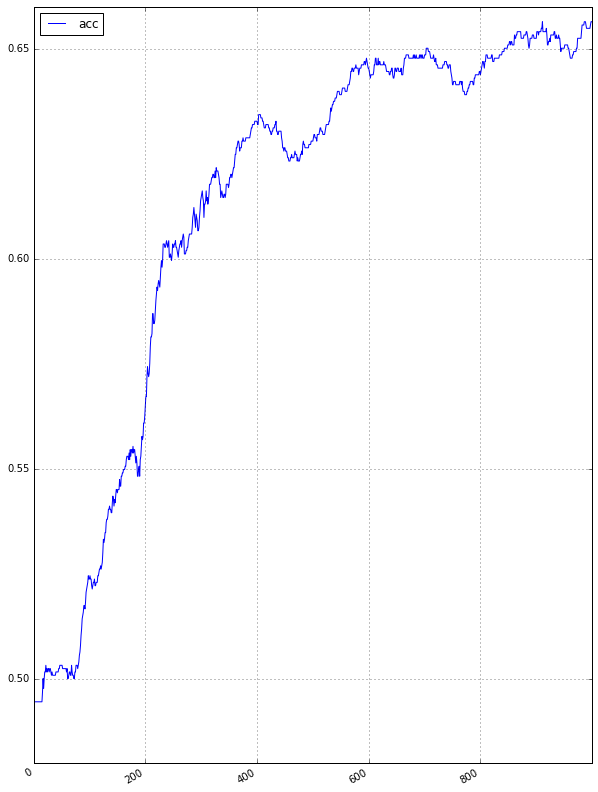

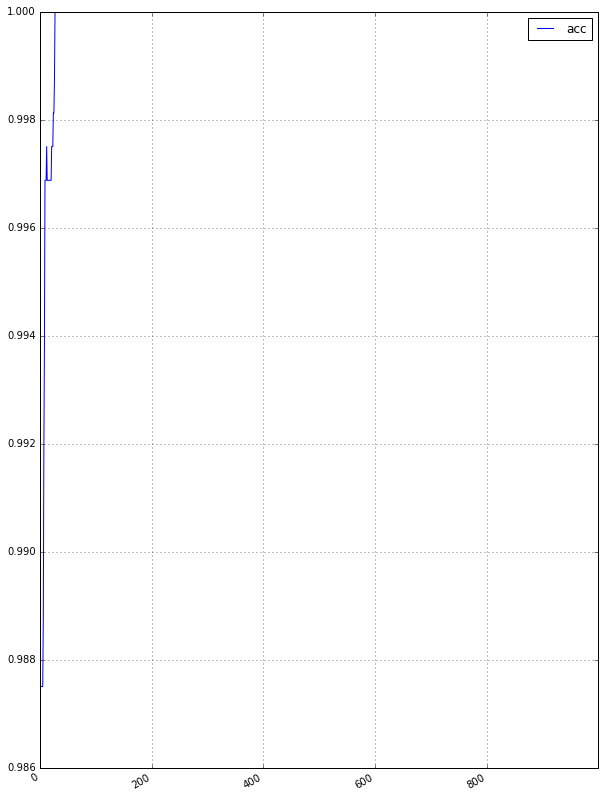

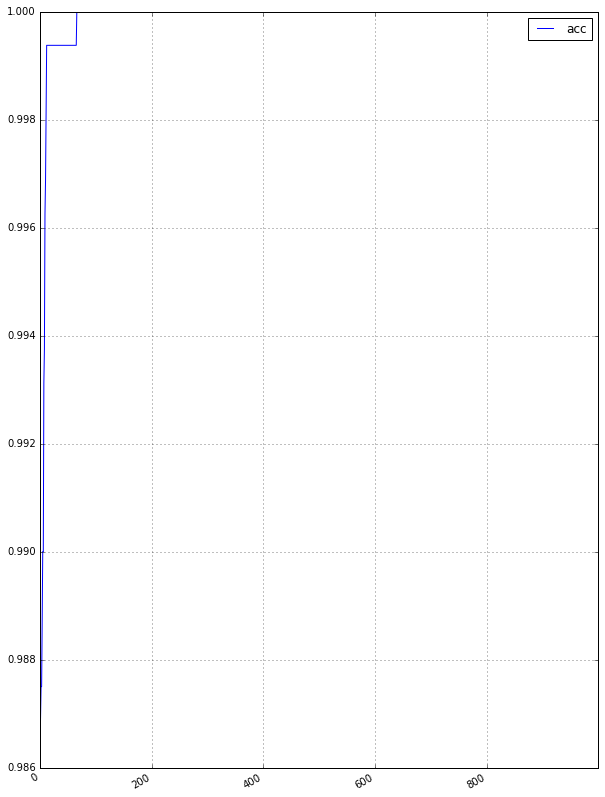

In [19]:
#Accuracy through Neural Network for all 4 datasets
print('Human Observed Dataset Concatenated')
NeuralNetwork(Data_Concatenated_HOD,TrainingData_Concatenated_HOD,TestData_Concatenated_HOD,ValData_Concatenated_HOD,TrainingTarget_HOD,TestDataTarget_HOD,ValDataTarget_HOD,'Concatenated','HOD')
print('---------------------------------------------------------')
print('Human Observed Dataset Subtracted')
NeuralNetwork(Data_Subtraction_HOD,TrainingData_Subtraction_HOD,TestData_Subtraction_HOD,ValData_Subtraction_HOD,TrainingTarget_HOD,TestDataTarget_HOD,ValDataTarget_HOD,'Subtract','HOD')
print('---------------------------------------------------------')
print('GSC Concatenated')
NeuralNetwork(Data_Concatenated_GSC,TrainingData_Concatenated_GSC,TestData_Concatenated_GSC,ValData_Concatenated_GSC,TrainingTarget_GSC,TestDataTarget_GSC,ValDataTarget_GSC,'Concatenated','GSC')
print('---------------------------------------------------------')
print('GSC Subtracted')
NeuralNetwork(Data_Subtraction_GSC,TrainingData_Subtraction_GSC,TestData_Subtraction_GSC,ValData_Subtraction_GSC,TrainingTarget_GSC,TestDataTarget_GSC,ValDataTarget_GSC,'Subtract','GSC')